![image](https://github.com/Lexie88rus/ds-bowl-2019/raw/master/assets/balls_cropped.jpg)

_Photo by [Greyson Joralemon on Unsplash](https://unsplash.com/photos/9IBqihqhuHc)_

# Data Science Bowl 2019 EDA
## Uncover the factors to help measure how young children learn

In [1]:
# imports
# basic tools
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# import plotting
import matplotlib.pyplot as plt
import seaborn as sns

## Introduction

In this competition we are challenged to predict how many attempts a child will take to pass a given assessment in a _PBS KIDS Measure Up! app_ using the  log of the previous gameplay events.

It is always helpful to explore the data before starting to engineer the features and creating the models. The data exploration is essential for this competition, because we have a huge volume of data, and we have to uncover the best features to save the computational resources. On the other hand, data exploration is a lot of fun!

In this notebook, I tried to find out __the factors, which affect the accuracy score__ using simple tools like pandas and matplotlib.

## Load Data

Quick reminder of what the columns mean from the [description of the competition](https://www.kaggle.com/c/data-science-bowl-2019):

__train.csv:__
_Gameplay events._

* `event_id` - Randomly generated unique identifier for the event type. Maps to `event_id` column in specs table.
* `game_session` - Randomly generated unique identifier grouping events within a single game or video play session.
* `timestamp` - Client-generated datetime
* `event_data` - Semi-structured JSON formatted string containing the events parameters. Default fields are: `event_count`, `event_code`, and `game_time`; otherwise fields are determined by the event type.
* `installation_id` - Randomly generated unique identifier grouping game sessions within a single installed application instance.
* `event_count` - Incremental counter of events within a game session (offset at 1). Extracted from event_data.
* `event_code` - Identifier of the event `class`. Unique per game, but may be duplicated across games. E.g. event code `2000` always identifies the `Start Game` event for all games. Extracted from event_data.
* `game_time` - Time in milliseconds since the start of the game session. Extracted from event_data.
* `title` - Title of the game or video.
* `type` - Media type of the game or video. Possible values are: `Game`, `Assessment`, `Activity`, `Clip`.
* `world` - The section of the application the game or video belongs to. Helpful to identify the educational curriculum goals of the media. Possible values are: `NONE` (at the app's start screen), `TREETOPCITY` (Length/Height), `MAGMAPEAK` (Capacity/Displacement), `CRYSTALCAVES` (Weight).

__specs.csv:__
_Specification of the various event types._

* `event_id` - Global unique identifier for the event type. Joins to `event_id` column in events table.
* `info` - Description of the event.
* `args` - JSON formatted string of event arguments. Each argument contains:
    * `name` - Argument name.
    * `type` - Type of the argument (string, int, number, object, array).
    * `info` - Description of the argument.

In [2]:
# setup the input folder
INPUT_PATH = '../input/data-science-bowl-2019/'

# load the csv files
train = pd.read_csv(INPUT_PATH + 'train.csv')
test = pd.read_csv(INPUT_PATH + 'test.csv')
specs = pd.read_csv(INPUT_PATH + 'specs.csv')
labels = pd.read_csv(INPUT_PATH + 'train_labels.csv')

In [3]:
train.head()

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
0,27253bdc,45bb1e1b6b50c07b,2019-09-06T17:53:46.937Z,"{""event_code"": 2000, ""event_count"": 1}",0001e90f,1,2000,0,Welcome to Lost Lagoon!,Clip,NONE
1,27253bdc,17eeb7f223665f53,2019-09-06T17:54:17.519Z,"{""event_code"": 2000, ""event_count"": 1}",0001e90f,1,2000,0,Magma Peak - Level 1,Clip,MAGMAPEAK
2,77261ab5,0848ef14a8dc6892,2019-09-06T17:54:56.302Z,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",0001e90f,1,2000,0,Sandcastle Builder (Activity),Activity,MAGMAPEAK
3,b2dba42b,0848ef14a8dc6892,2019-09-06T17:54:56.387Z,"{""description"":""Let's build a sandcastle! Firs...",0001e90f,2,3010,53,Sandcastle Builder (Activity),Activity,MAGMAPEAK
4,1bb5fbdb,0848ef14a8dc6892,2019-09-06T17:55:03.253Z,"{""description"":""Let's build a sandcastle! Firs...",0001e90f,3,3110,6972,Sandcastle Builder (Activity),Activity,MAGMAPEAK


In [4]:
test.head()

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
0,27253bdc,0ea9ecc81a565215,2019-09-10T16:50:24.910Z,"{""event_code"": 2000, ""event_count"": 1}",00abaee7,1,2000,0,Welcome to Lost Lagoon!,Clip,NONE
1,27253bdc,c1ea43d8b8261d27,2019-09-10T16:50:55.503Z,"{""event_code"": 2000, ""event_count"": 1}",00abaee7,1,2000,0,Magma Peak - Level 1,Clip,MAGMAPEAK
2,27253bdc,7ed86c6b72e725e2,2019-09-10T16:51:51.805Z,"{""event_code"": 2000, ""event_count"": 1}",00abaee7,1,2000,0,Magma Peak - Level 2,Clip,MAGMAPEAK
3,27253bdc,7e516ace50e7fe67,2019-09-10T16:53:12.825Z,"{""event_code"": 2000, ""event_count"": 1}",00abaee7,1,2000,0,Crystal Caves - Level 1,Clip,CRYSTALCAVES
4,7d093bf9,a022c3f60ba547e7,2019-09-10T16:54:12.115Z,"{""version"":""1.0"",""round"":0,""event_count"":1,""ga...",00abaee7,1,2000,0,Chow Time,Game,CRYSTALCAVES


In [5]:
specs.head()

,event_id,info,args
0,2b9272f4,The end of system-initiated feedback (Correct)...,"[{""name"":""game_time"",""type"":""int"",""info"":""mill..."
1,df4fe8b6,The end of system-initiated feedback (Incorrec...,"[{""name"":""game_time"",""type"":""int"",""info"":""mill..."
2,3babcb9b,The end of system-initiated instruction event ...,"[{""name"":""game_time"",""type"":""int"",""info"":""mill..."
3,7f0836bf,The end of system-initiated instruction event ...,"[{""name"":""game_time"",""type"":""int"",""info"":""mill..."
4,ab3136ba,The end of system-initiated instruction event ...,"[{""name"":""game_time"",""type"":""int"",""info"":""mill..."


In [6]:
labels.head()

,game_session,installation_id,title,num_correct,num_incorrect,accuracy,accuracy_group
0,6bdf9623adc94d89,0006a69f,Mushroom Sorter (Assessment),1,0,1.0,3
1,77b8ee947eb84b4e,0006a69f,Bird Measurer (Assessment),0,11,0.0,0
2,901acc108f55a5a1,0006a69f,Mushroom Sorter (Assessment),1,0,1.0,3
3,9501794defd84e4d,0006a69f,Mushroom Sorter (Assessment),1,1,0.5,2
4,a9ef3ecb3d1acc6a,0006a69f,Bird Measurer (Assessment),1,0,1.0,3


## Explore the Datasets

`1` Explore the number of rows in train and test sets:

In [7]:
train_rows = len(train)
test_rows = len(test)

print('The number of rows in the train set is {}'.format(train_rows))
print('The number of rows in the test set is {}'.format(test_rows))

The number of rows in the train set is 11341042
The number of rows in the test set is 1156414


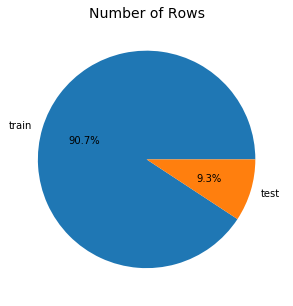

In [8]:
plt.figure(figsize=(5,5))
plt.pie([train_rows, test_rows], labels = ['train', 'test'], autopct='%1.1f%%')
plt.title('Number of Rows', fontsize = 14)
plt.show()

We have a large train set which is almost 10 times greater than the test set.

## Explore the Users

`1` Number of unique users in train and test sets:

In [9]:
inst_train = train.installation_id.unique()
inst_test = test.installation_id.unique()

print('Number of players in the train set is {}'.format(len(inst_train)))
print('Number of players in the test set is {}'.format(len(inst_test)))

Number of players in the train set is 17000
Number of players in the test set is 1000


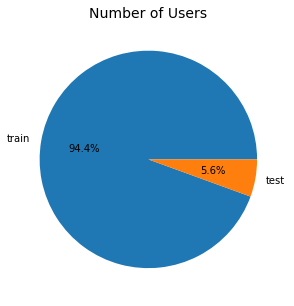

In [10]:
plt.figure(figsize=(5,5))
plt.pie([len(inst_train), len(inst_test)], labels = ['train', 'test'], autopct='%1.1f%%')
plt.title('Number of Users', fontsize = 14)
plt.show()

`2` Overlapping users between train and test sets:

In [11]:
# try to find the intersection between installation ids in train and test sets
common_users = list(set(inst_train).intersection(set(inst_test)))
common_users

[]

There are no overlapping users between the train and the test set.

`3` The number of events per user:

In [12]:
# calculate the number of entries in each dataset per installation_id
train_user_events = train['installation_id'].value_counts()
test_user_events = test['installation_id'].value_counts()

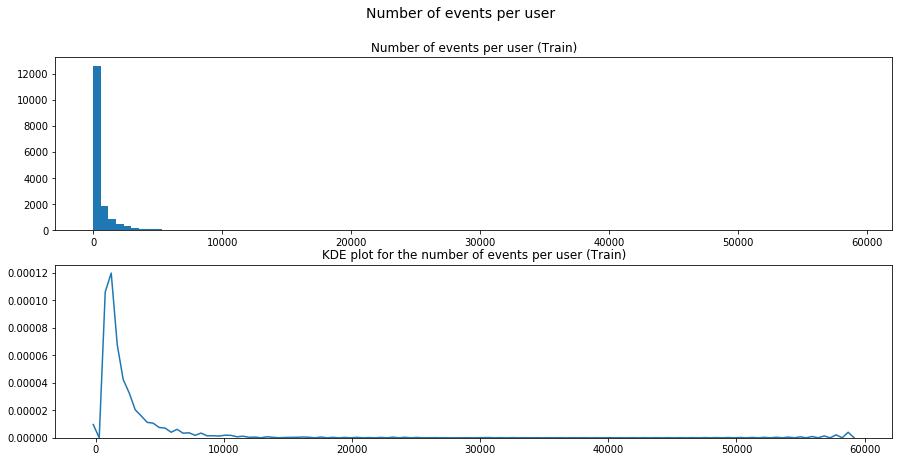

In [13]:
fig, axs = plt.subplots(2, 1, figsize = (15,7))

axs[0].hist(train_user_events.values, bins = 100)
axs[0].set_title('Number of events per user (Train)')

axs[1] = sns.kdeplot(train_user_events.values)
axs[1].set_title('KDE plot for the number of events per user (Train)')

plt.suptitle('Number of events per user', fontsize = 14)
plt.show()

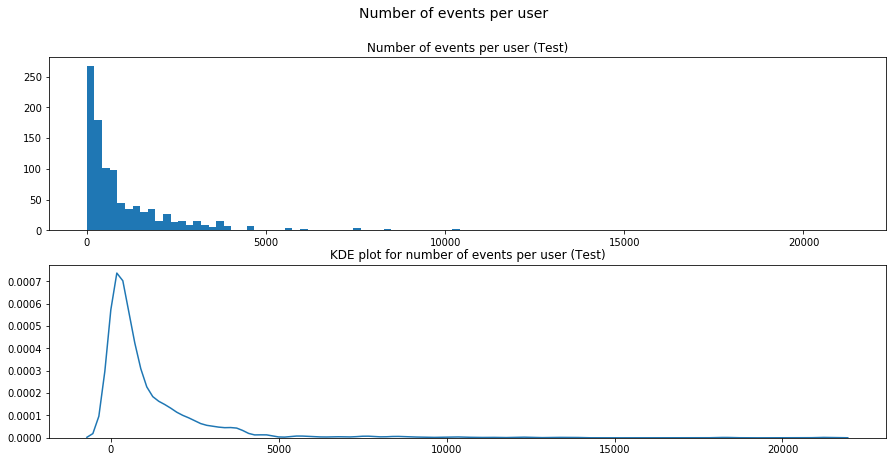

In [14]:
fig, axs = plt.subplots(2, 1, figsize = (15,7))

axs[0].hist(test_user_events.values, bins = 100)
axs[0].set_title('Number of events per user (Test)')

axs[1] = sns.kdeplot(test_user_events.values)
axs[1].set_title('KDE plot for number of events per user (Test)')

plt.suptitle('Number of events per user', fontsize = 14)
plt.show()

The top active users for train set:

In [15]:
pd.DataFrame(train_user_events).head()

,installation_id
f1c21eda,58988
4d7d3d97,32749
d25338cb,31826
cff5a334,30918
c9ea32e9,30402


__The most active users have more than 30000 events!__

Let's look at accuracy scores depending on the number of events per user:

In [16]:
# mean accuracy group per installation_id 
user_acc_groups = labels.groupby(by=['installation_id'])[['accuracy_group']].mean()

# join with the number of events per user
user_event_acc = pd.DataFrame(train_user_events).join(user_acc_groups).rename(columns={'installation_id':'num_events'})

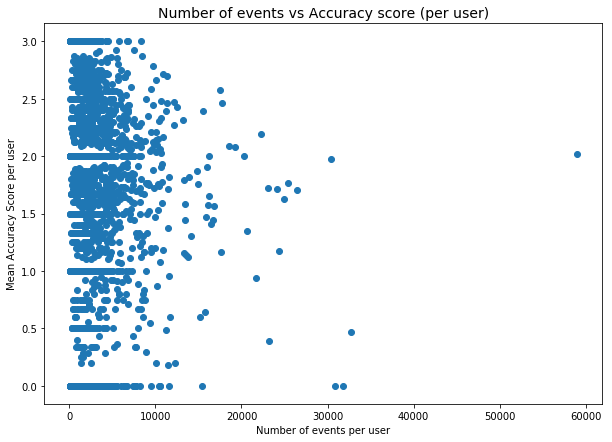

In [17]:
plt.subplots(1, figsize=(10,7))
plt.scatter(user_event_acc.num_events, user_event_acc.accuracy_group)
plt.title('Number of events vs Accuracy score (per user)', fontsize = 14)
plt.xlabel('Number of events per user')
plt.ylabel('Mean Accuracy Score per user')
plt.show()

This diagram doesn't show the strong correlation between the number of events per user and their accuracy scores. Maybe some kids just enjoy playing games and watching clips.

`4` The number of game sessions per user:

In [18]:
# get number of sessions per user and sort in desc order
sessions_count = train.groupby(by=['game_session', 'installation_id']).count()[['event_id']]\
.rename(columns={'event_id':'sessions'})
sessions_count_inst = sessions_count.reset_index().groupby(by=['installation_id']).count()[['game_session']].sort_values(by = 'game_session', ascending=False)
sessions_count_inst.head()

,game_session
installation_id,
f1c21eda,1260
9f399a3a,1190
08987c08,990
cff5a334,839
4d7d3d97,760


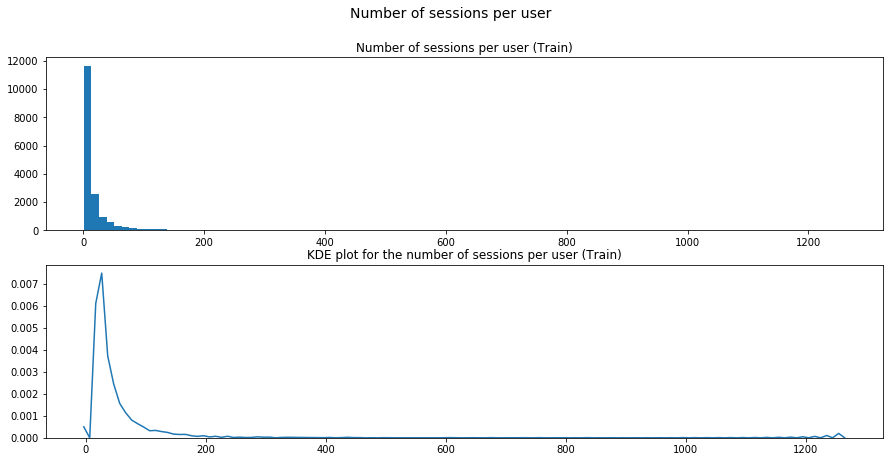

In [19]:
fig, axs = plt.subplots(2, 1, figsize = (15,7))

axs[0].hist(sessions_count_inst['game_session'].values, bins = 100)
axs[0].set_title('Number of sessions per user (Train)')

axs[1] = sns.kdeplot(sessions_count_inst['game_session'].values)
axs[1].set_title('KDE plot for the number of sessions per user (Train)')

plt.suptitle('Number of sessions per user', fontsize = 14)
plt.show()

Let's try to merge the number of sessions and the accuracy score:

In [20]:
# mean accuracy group per installation_id 
user_acc_groups = labels.groupby(by=['installation_id'])[['accuracy_group']].mean()

# join with the number of events per user
user_sessions_acc = pd.DataFrame(user_acc_groups).join(sessions_count_inst).rename(columns={'installation_id':'num_sessions'})

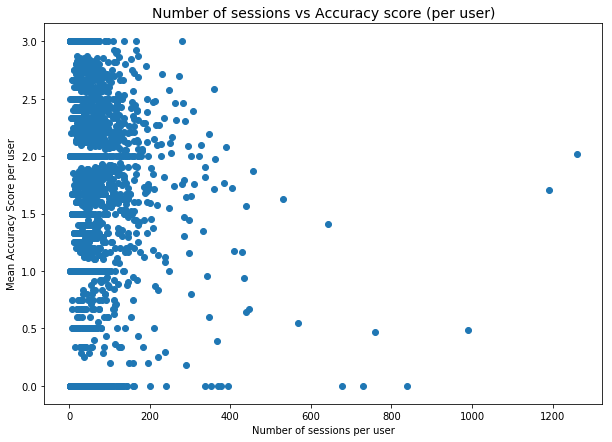

In [21]:
plt.subplots(1, figsize=(10,7))
plt.scatter(user_sessions_acc.game_session, user_sessions_acc.accuracy_group)
plt.title('Number of sessions vs Accuracy score (per user)', fontsize = 14)
plt.xlabel('Number of sessions per user')
plt.ylabel('Mean Accuracy Score per user')
plt.show()

Almost the same picture as for the number of events. Still there is no strong correlation between the number of sessions and the accuracy score of the user.

## Explore the Events

`1` Explore the event codes:

In [22]:
event_codes = train.event_code.value_counts()
event_codes_test = test.event_code.value_counts()

print('There are {} different event codes in the train set.'.format(len(event_codes)))
print('There are {} different event codes in the test set.'.format(len(event_codes_test)))

There are 42 different event codes in the train set.
There are 42 different event codes in the test set.


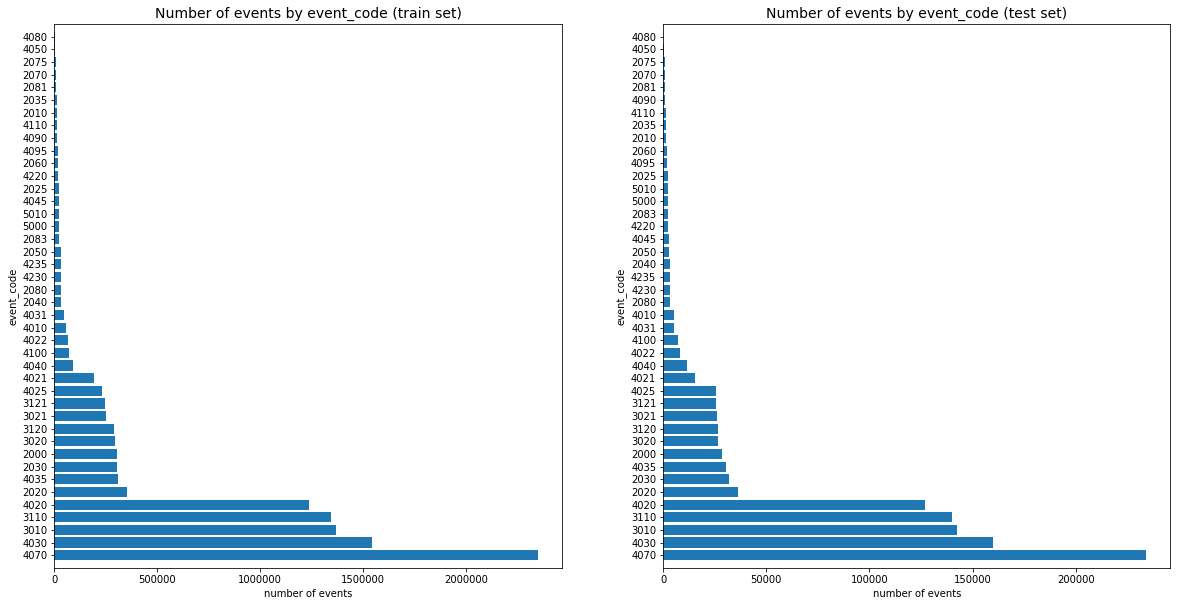

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(20,10))

axs[0].barh(range(0, len(event_codes)), event_codes.values)
axs[0].set_yticks(range(0, len(event_codes)))
axs[0].set_yticklabels(event_codes.index)
axs[0].set_ylim(-1, len(event_codes))
axs[0].set_ylabel('event_code')
axs[0].set_xlabel('number of events')
axs[0].set_title('Number of events by event_code (train set)', fontsize=14)

axs[1].barh(range(0, len(event_codes_test)), event_codes_test.values)
axs[1].set_yticks(range(0, len(event_codes_test)))
axs[1].set_yticklabels(event_codes_test.index)
axs[1].set_ylim(-1, len(event_codes_test))
axs[1].set_ylabel('event_code')
axs[1].set_xlabel('number of events')
axs[1].set_title('Number of events by event_code (test set)', fontsize=14)

plt.show()

The frequencies of the events for the test and the train sets look very similar, except for the fact that we have 10 times more events in the train set.

`2` Number of events per media type:

In [24]:
media_types_train = train.type.value_counts()
media_types_test = test.type.value_counts()

[]

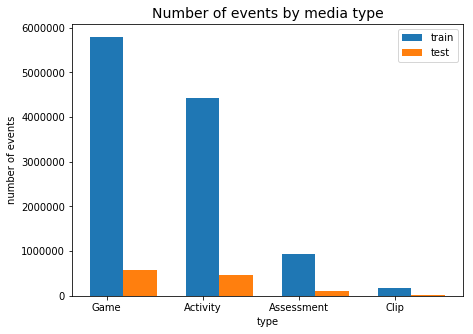

In [25]:
plt.subplots(1, figsize=(7,5))
width = 0.35
plt.bar(np.arange(0, len(media_types_train)), media_types_train.values, width, label = 'train')
plt.bar(np.arange(0, len(media_types_test)) + width, media_types_test.values, width, label = 'test')
plt.xticks(range(0, len(media_types_train)), media_types_train.index)
plt.xlabel('type')
plt.ylabel('number of events')
plt.title('Number of events by media type', fontsize=14)
plt.legend()
plt.plot()

The `Game` is the most popular event type!!!

`3` Number of events per world:

In [26]:
# get the number of events for each world (sort by world name to plot correctly)
world_train = pd.DataFrame(train.world.value_counts().reset_index().sort_values(by=['index']).rename(columns={'index':'world_name'}))
world_test = pd.DataFrame(test.world.value_counts().reset_index().sort_values(by=['index']).rename(columns={'index':'world_name'}))

[]

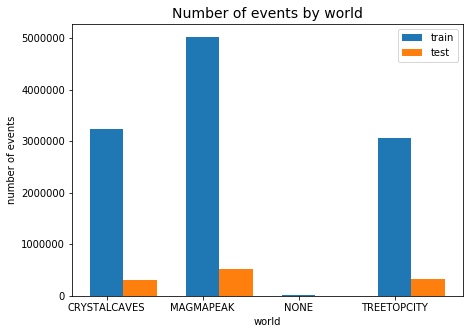

In [27]:
# plot bar charts
plt.subplots(1, figsize=(7,5))
width = 0.35
plt.bar(np.arange(0, len(world_train)), world_train.world.values, width, label = 'train')
plt.bar(np.arange(0, len(world_test)) + width, world_test.world.values, width, label = 'test')
plt.xticks(range(0, len(world_train)), world_train.world_name.values)
plt.xlabel('world')
plt.ylabel('number of events')
plt.title('Number of events by world', fontsize=14)
plt.legend()
plt.plot()

The distribution of event worlds in train and test datasets is a bit different. `CRYSTALCAVES` is more popular in train set than `TREETOPCITY`, but `TREETOPCITY` is more popular in the test set.

## Explore the Accuracy Groups

`1` Overall mean accuracy group:

In [28]:
acc_mean = labels.accuracy_group.mean()

print('The mean accuracy is {}'.format(acc_mean))

The mean accuracy is 1.8855850763143018


`2` Accuracy group by the user

In [29]:
# find mean accuracies per user
acc_user_mean = labels.groupby(by=['installation_id'])['accuracy_group'].mean()

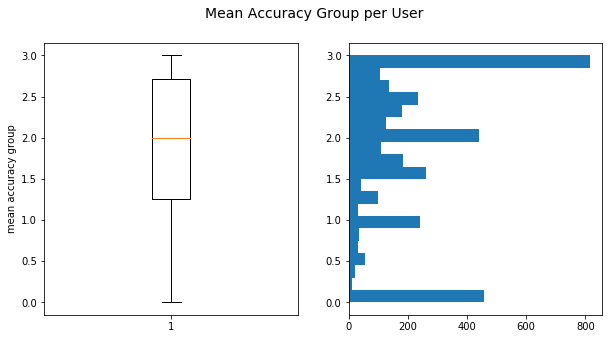

In [30]:
fig, axs = plt.subplots(1,2, figsize=(10,5))

axs[0].boxplot(acc_user_mean)
axs[0].set_ylabel('mean accuracy group')

axs[1].hist(acc_user_mean, bins=20, orientation="horizontal")

plt.suptitle('Mean Accuracy Group per User', fontsize=14)
plt.show()

Honestly, I was expecting a bell-shaped distribution for the accuracy scores. But the distribution turns out to be of a way more interesting shape.

`3` Accuracy group by the game title:

In [31]:
acc_title_mean = labels.groupby(by=['title'])['accuracy_group'].mean()

In [32]:
# Source:
# https://stackoverflow.com/questions/28931224/adding-value-labels-on-a-matplotlib-bar-chart
def add_value_labels(ax, spacing=5):
    """Add labels to the end of each bar in a bar chart.

    Arguments:
        ax (matplotlib.axes.Axes): The matplotlib object containing the axes
            of the plot to annotate.
        spacing (int): The distance between the labels and the bars.
    """

    # For each bar: Place a label
    for rect in ax.patches:
        # Get X and Y placement of label from rect.
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        # Number of points between bar and label. Change to your liking.
        space = spacing
        # Vertical alignment for positive values
        va = 'bottom'

        # If value of bar is negative: Place label below bar
        if y_value < 0:
            # Invert space to place label below
            space *= -1
            # Vertically align label at top
            va = 'top'

        # Use Y value as label and format number with one decimal place
        label = "{:.1f}".format(y_value)

        # Create annotation
        ax.annotate(
            label,                      # Use `label` as label
            (x_value, y_value),         # Place label at end of the bar
            xytext=(0, space),          # Vertically shift label by `space`
            textcoords="offset points", # Interpret `xytext` as offset in points
            ha='center',                # Horizontally center label
            va=va)                      # Vertically align label differently for
                                        # positive and negative values.

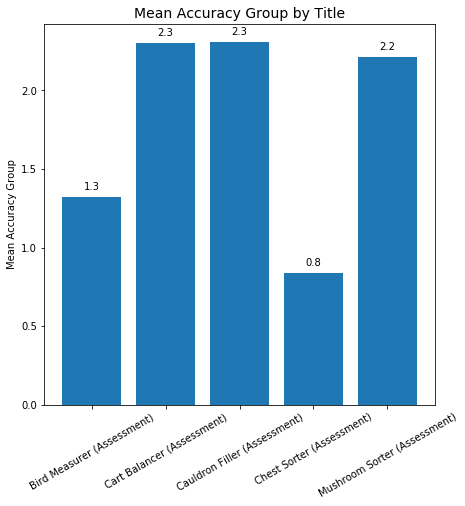

In [33]:
fig, ax = plt.subplots(1, figsize = (7,7))
plt.bar(range(0, len(acc_title_mean)), acc_title_mean)
plt.xticks(range(0, len(acc_title_mean)), acc_title_mean.index, rotation = 30)
plt.title('Mean Accuracy Group by Title', fontsize = 14)
plt.ylabel('Mean Accuracy Group')
add_value_labels(ax)
plt.show()

It seems that some assessments like Chest Sorter and Bird Measurer are way more difficult than the other assessments.

Let's look closer:

In [34]:
# get title names
titles = labels.title.unique()

# get accuracy scores for each title
acc_scores = {}
for title in titles:
    acc_score_title = labels[labels.title == title][['title', 'accuracy_group']]
    acc_scores[title] = acc_score_title

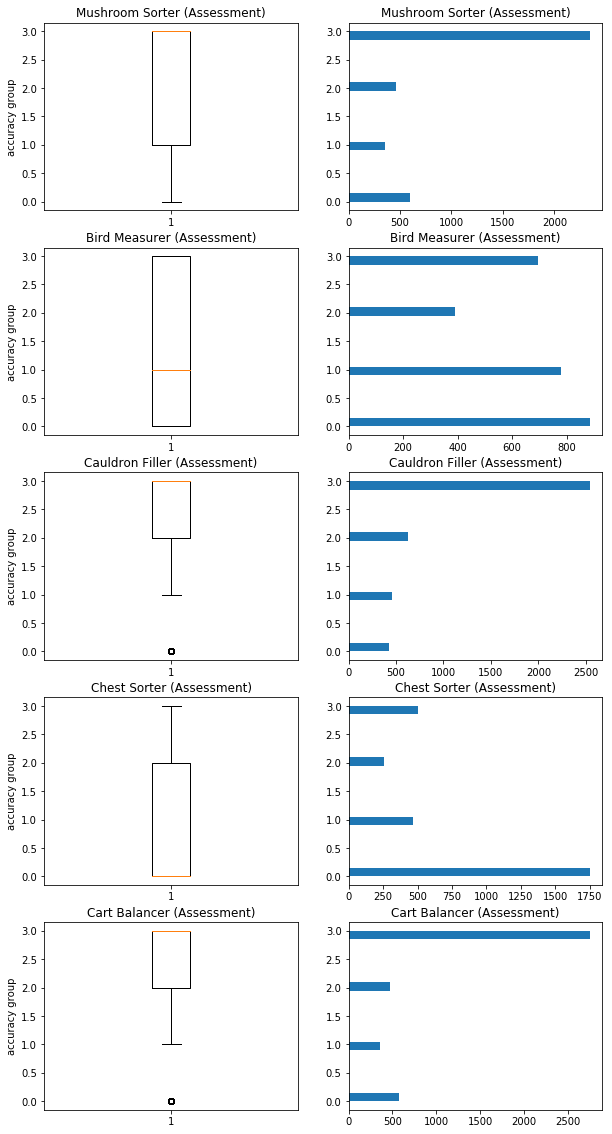

In [35]:
# plot distributions
fig, axs = plt.subplots(len(titles), 2, figsize=(10, 20))

for i in range(len(titles)):
    axs[i,0].boxplot(acc_scores[titles[i]]['accuracy_group'])
    axs[i,0].set_ylabel('accuracy group')
    axs[i,0].set_title(titles[i])
    
    axs[i,1].hist(acc_scores[titles[i]]['accuracy_group'], bins = 20, orientation="horizontal")
    axs[i,1].set_title(titles[i])

plt.show()

We can see that the `Bird Measurer` and the `Chest Sorter` are the most difficult assessments.

`4` Analyze dependencies between the `accuracy_group` and `event_count`:

In [36]:
# merge accuracy groups with game_time and event_count information
assm_events = train[train['type'] == 'Assessment'][['game_session','event_count', 'game_time']]
assm_events = assm_events.merge(labels, on = ['game_session'])

# group by event_count
assm_events_counts = assm_events.groupby(by=['event_count'])['accuracy_group'].mean()

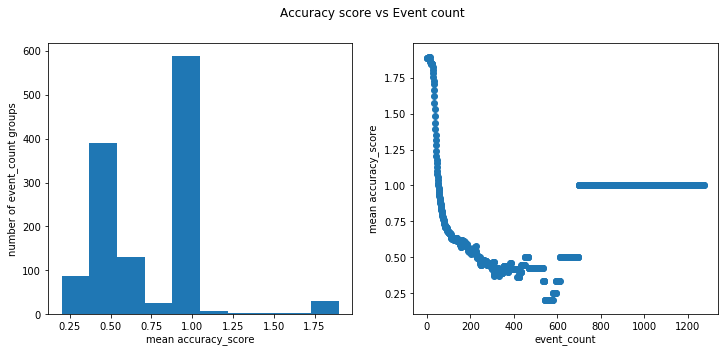

In [37]:
fig, axs = plt.subplots(1,2,figsize=(12,5))

axs[0].hist(assm_events_counts)
axs[0].set_xlabel('mean accuracy_score')
axs[0].set_ylabel('number of event_count groups')

axs[1].scatter(assm_events_counts.index, assm_events_counts)
axs[1].set_xlabel('event_count')
axs[1].set_ylabel('mean accuracy_score')

plt.suptitle('Accuracy score vs Event count')
plt.show()

The diagrams above in fact show the mean accuracy score vs the number of attempts. The fewer number of attempts is used to pass an assessment the greater resulting accuracy score is.

In [38]:
# group by game_time
assm_events_time = assm_events.groupby(by=['game_time'])['accuracy_group'].mean()

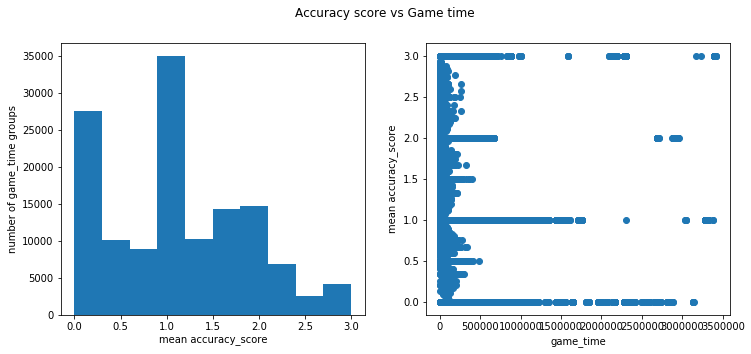

In [39]:
fig, axs = plt.subplots(1,2,figsize=(12,5))

axs[0].hist(assm_events_time[:-1000])
axs[0].set_xlabel('mean accuracy_score')
axs[0].set_ylabel('number of game_time groups')

axs[1].scatter(assm_events_time.index[:-1000], assm_events_time[:-1000])
axs[1].set_xlabel('game_time')
axs[1].set_ylabel('mean accuracy_score')

plt.suptitle('Accuracy score vs Game time')
plt.show()

## Conclusions:
In this kernel I analyzed the PBS KIDS _Measure Up!_ app data, which consists of gaming event logs and tried to find factors, which affect the accuracy group. Those factors can be include the __type of the assessment (Title)__, because some assessments (Chest Sorter and Bird Measurer) seem to be just more difficult.